# gpie-ptychography User Guide

This notebook provides an overview of the core concepts and usage patterns of the `gpie-ptychography` module.  
Its purpose is **not** to demonstrate phase-retrieval or reconstruction algorithms, but to explain how to build and simulate *synthetic ptychography data* using the infrastructure provided by the library.

In `gpie-ptychography`, the numerical model of ptychography is organized around a clear separation of concerns:

- **Computation graph**: a symbolic representation of the ptychography forward model, describing how waves, propagators, and measurements are connected.
- **Context**: a collection of experimental and geometric parameters, such as scan positions, pixel size, and array shapes, which define the physical setup of the
  experiment.

These two components are bound together in a `PtychoModel` object.  
Users interact primarily with this object to set concrete data (e.g. probe or object), run forward simulations, and access the resulting synthetic diffraction data.

This notebook introduces this mental model step by step and illustrates how the different components fit together in practice.


In [99]:
import numpy as np
import itertools                    # for limiting scan generators


# Core ptychography data structures
from ptychography.data import PtychoContext

# Scan geometry generators
from ptychography.scan import raster_scan

# Optics utilities (probe generation)
from ptychography.optics import generate_probe

# Visualization helpers (thin wrappers around matplotlib)
from ptychography.visualization import (
    plot_scan_positions,
    plot_wave,
    plot_diffraction_grid,
)

import matplotlib.pyplot as plt

## Defining scan geometry and experimental context

We start by defining the *scan geometry* and the *experimental context*.

In ptychography, scan positions specify where the probe illuminates the object in real space. In `gpie-ptychography`, scan positions are generated using a generator function. 

The experimental setup is then summarized in a `PtychoContext` object.
The context collects all geometric and physical parameters that define the (discritized) forward model, such as:

- scan positions in real space
- object and probe array shapes
- pixel size (real-space length per pixel)

The context does *not* contain any array-data or computation graph.


In [100]:
# ------------------------------------------------------------
# Generate scan positions in real space
# ------------------------------------------------------------

# raster_scan yields an infinite generator of (x, y) positions.
# Here we take only the first N positions for a small synthetic example.
n_scan = 25

scan_positions = list(
    itertools.islice(
        raster_scan(stride=1.0, jitter = 0.05),  # stride: spacing between scan positions, jitter: standard deviation of random jitter
        n_scan
    )
)

# ------------------------------------------------------------
# Construct the ptychography context
# ------------------------------------------------------------

ctx = PtychoContext(
    scan_positions=scan_positions,
    object_shape=(512, 512),  # size of the object array (Ny, Nx)
    probe_shape=(128, 128),     # size of the probe array (Ny, Nx)
    pixel_pitch=0.1,          # real-space length per pixel
)

# Inspect the context
ctx


PtychoContext(
  n_scan       = 25
  requested    = 25
  object_shape = (512, 512)
  probe_shape  = (128, 128)
  pixel_pitch  = 0.1
)

## Visualizing scan positions

Before moving on, let us visually inspect the scan geometry.

The function `plot_scan_positions` provides a helper for plotting the scan positions stored in a `PtychoContext`. It outputs `axes` object of `matplotlib` and users can customize detailed settings.

Text(0, 0.5, 'y')

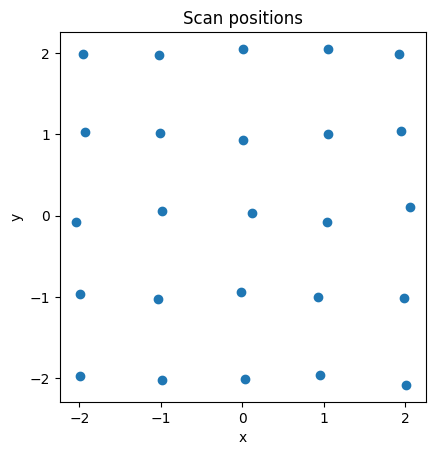

In [101]:
# Visualize scan positions

ax = plot_scan_positions(ctx)

ax.set_title("Scan positions")
ax.set_xlabel("x")
ax.set_ylabel("y")

## Probe generation model

In this example, the probe is generated using a simple *soft-aperture model*.

The basic idea is to define an aperture function either in real space or in Fourier space, optionally apply a smooth random phase modulation to model aberrations, and then obtain the real-space probe field.

The parameter `aperture_radius` controls the effective size of the aperture. When the aperture is interpreted in Fourier space, this radius is defined in terms of the normalized frequency coordinates returned by `fftfreq`.

This model is not intended to represent a specific microscope configuration, but provides a flexible and physically reasonable way to generate synthetic probe fields for numerical experiments.


In [102]:
# ------------------------------------------------------------
# Generate a synthetic probe using a soft-aperture model
# ------------------------------------------------------------

probe = generate_probe(
    shape=ctx.probe_shape,     # Probe array shape (Ny, Nx)
    pixel_size=ctx.pixel_pitch,            # Physical pixel size (arbitrary units)
    aperture_radius=1.0,       # Aperture radius in normalized frequency units
    kind="circular",           # Circular aperture
    space="fourier",           # Aperture defined in Fourier space
    smooth_edge_sigma=0.1,    # Smooth edge width (fraction of radius)
    random_phase=False,         # Apply smooth random phase aberration
    rng=np.random.default_rng(0),
)

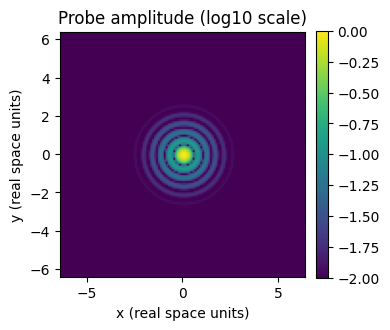

In [103]:
# ------------------------------------------------------------
# Probe amplitude with real-space scale
# ------------------------------------------------------------

fig, ax = plt.subplots(figsize=(4, 4))

amp = np.abs(probe)
log_amp = np.log10(amp + 1e-6)

ny, nx = probe.shape
pixel_pitch = ctx.pixel_pitch

# Define real-space extent (centered at zero)
extent = (
    -0.5 * nx * pixel_pitch,
     0.5 * nx * pixel_pitch,
    -0.5 * ny * pixel_pitch,
     0.5 * ny * pixel_pitch,
)

im = ax.imshow(
    log_amp,
    cmap="viridis",
    vmin=-2.0,
    vmax=0.0,
    extent=extent,
)

ax.set_title("Probe amplitude (log10 scale)")
ax.set_xlabel("x (real space units)")
ax.set_ylabel("y (real space units)")

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()